In [1]:
import os
import pandas as pd
import numpy as np
import umap
import hdbscan
import matplotlib.pyplot as plt
import data
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from  sklearn.metrics.pairwise import cosine_similarity
from random import sample

## Read and Split Data

In [6]:
data_path = "data/negotiate"
lines = []
file_name = os.path.join(data_path, 'data.txt')
with open(file_name, 'r') as f:
    for line in f:
        lines.append(line.strip())
g =  [line[:12] for line in lines]
o =  [line[-12:] for line in lines]
selection = [line[12:-12].split('<eos>')[-2].split('<selection>')[1] for line in lines]
rew = [line[12:-12].split('<eos>')[-1][8:] for line in lines]
dialog = [line[12:-12].split('<eos>')[:-2] for line in lines]

In [7]:
df = pd.DataFrame({'g':g, 'dialog':dialog, 'selection':selection, 'reward':rew, 'outcome':o})
df.head()

,g,dialog,selection,reward,outcome
0,1 0 4 2 1 2,[YOU: i would like 4 hats and you can have the...,item0=0 item1=4 item2=0,8 agree,1 4 4 1 1 2
1,1 4 4 1 1 2,[THEM: i would like 4 hats and you can have th...,item0=1 item1=0 item2=1,6 agree,1 0 4 2 1 2
2,1 6 3 0 2 2,[YOU: you can have all the hats if i get the b...,item0=1 item1=3 item2=2,10 disagree,1 2 3 2 2 1
3,1 10 3 0 1 0,[ YOU: hi i would like the book and ball and y...,item0=1 item1=0 item2=0,10 agree,1 2 3 2 1 2
4,1 2 3 2 1 2,[THEM: hi i would like the book and ball and y...,item0=0 item1=3 item2=1,8 agree,1 10 3 0 1 0


In [8]:
sents = []

for d in df['dialog']:
    for sent in d:
        s = sent.strip()
        if s[:3] == 'YOU':
            sents.append(s[4:].strip())

# Embedding and Dimension Reduction

In [10]:

model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(sents, show_progress_bar=True)

Batches:   0%|          | 0/955 [00:00<?, ?it/s]

In [24]:
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

# HDBScan Clustering

In [25]:
cluster = hdbscan.HDBSCAN(min_cluster_size=100,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

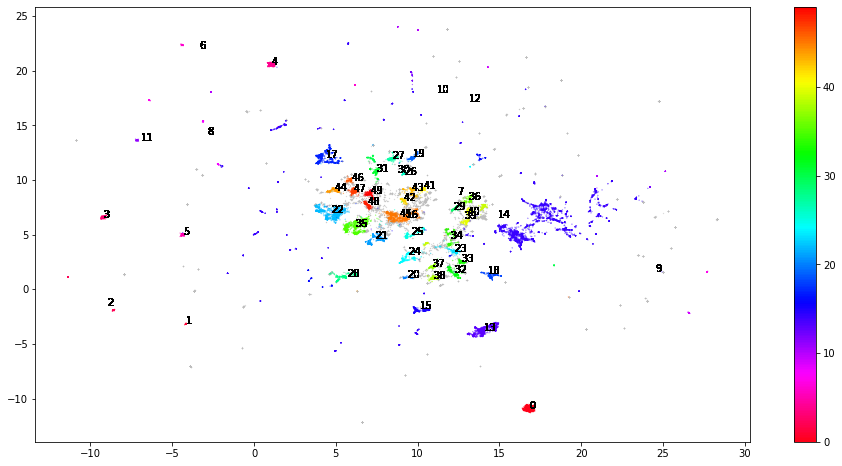

In [26]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(16, 8))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
for i in clustered.labels:
    plt.annotate(i, (np.mean(clustered[clustered['labels'] == i].x),  np.mean(clustered[clustered['labels'] == i].y)))
plt.colorbar()

# Merge Similar Topics

In [27]:
docs_df = pd.DataFrame(sents, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [28]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(sents))

In [29]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out ()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df)

In [30]:

n_merge = 20
for i in range(n_merge):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(sents)
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

topic_sizes = extract_topic_sizes(docs_df)

# Re-plot Merged

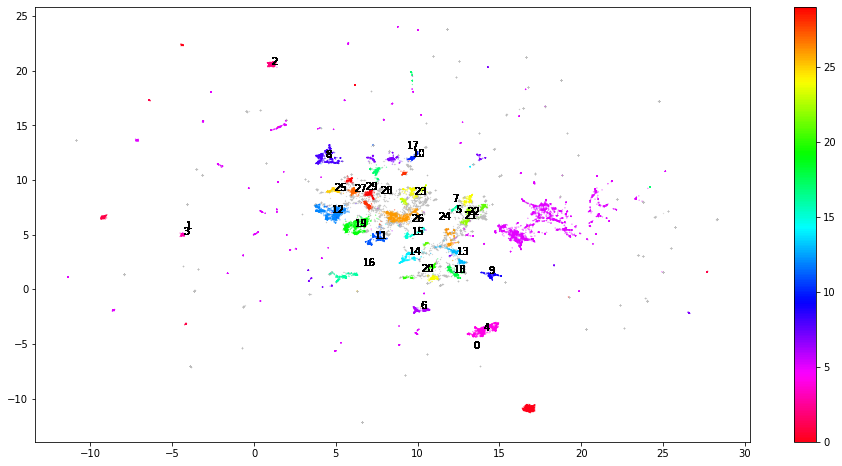

In [31]:
# Prepare data
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = docs_df.Topic

# Visualize clusters
fig, ax = plt.subplots(figsize=(16, 8))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
for i in clustered.labels:
    plt.annotate(i, (np.mean(clustered[clustered['labels'] == i].x),  np.mean(clustered[clustered['labels'] == i].y)))
plt.colorbar()

# Cluster Distribution and Samples

In [32]:
topic_sizes.head(10)

,Topic,Size
0,-1,7154
6,5,5438
1,0,1485
5,4,1334
13,12,1287
20,19,1108
27,26,1032
9,8,978
2,1,922
3,2,803


In [33]:
sent_df = pd.DataFrame({"text":sents, "cluster":cluster.labels_})

In [34]:
def get_examples(df, clusters,  n=10):
    examples = dict()
    for c in clusters:
        cluster_examples = list()
        cluster_examples.extend(sample(list(df[df['cluster'] == c].text),n))
        examples[c] = cluster_examples
    return examples

In [35]:
top_n = 20
examples = get_examples(sent_df, topic_sizes['Topic'][1:top_n+1])
print(f"Top {top_n} Largest Clusters: Random Example Messages")
for k in examples.keys():
    print("#"*30 + "\n")
    print(f"Sample messages for cluster {k}:\n")
    [print(m) for m in examples[k]]
    print("\n")

Top 20 Largest Clusters: Random Example Messages
##############################

Sample messages for cluster 5:

deal .
deal .
deal .
deal .
deal .
deal .
deal .
deal .
deal .
deal .


##############################

Sample messages for cluster 0:

deal
deal
deal
deal
deal
deal
deal
deal
deal
deal


##############################

Sample messages for cluster 4:

no deal
no deal
no deal
no deal
no deal
no deal
no deal
no deal
no deal
no deal


##############################

Sample messages for cluster 12:

nah
no
no .
no
no
no
no ,
no
no
no


##############################

Sample messages for cluster 19:

take the hats and a book
can i have the hats and the book
i will take the books and the hat
you can have the hats if i get the book .
i guess i can trade a book for the hat
i will take the hat and the books .
both books and the hat please .
i'll take a hat and a book
can you trade either a ball or hat for a book ?
books and hats


##############################

Sample messages for c

In [36]:
print(f"Top {top_n} Largest Clusters: Key Terms (TFIDF)")
for i in topic_sizes['Topic'][1:top_n+1]:
    print("#"*30 + "\n")
    print(f"Top words for cluster {i}:\n")
    [print(m[0], ": ", m[1]) for m in top_n_words[i][:10]]
    print("\n")

Top 20 Largest Clusters: Key Terms (TFIDF)
##############################

Top words for cluster 5:

deal :  0.21211633656928403
okay :  0.17955756367062653
yes :  0.1439456216923384
thank :  0.13549809116399225
sounds :  0.1353860936997741
good :  0.12393182032792147
ok :  0.09184467477335043
sorry :  0.08440846915833607
great :  0.08280525093804365
button :  0.07306957680637576


##############################

Top words for cluster 0:

deal :  1.487535567819703
balls :  0.02783121765374457
hats :  0.027078355105763993
book :  0.018342826812261712
deall :  0.006275862485509409
books :  0.004517403497373844
case :  0.004511660400100803
definitely :  0.004324245369187591
ger :  0.0
genius :  0.0


##############################

Top words for cluster 4:

balls :  0.18240932423422868
hats :  0.18208010665862764
books :  0.17764580684203796
book :  0.13130747653416555
hat :  0.12930957550056632
ball :  0.12517452775488244
need :  0.09959953193222916
ll :  0.08948575571850084
like :  0.06